In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

## Define Tools
Define some tools that our agents will use in the future

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Create graph
After tools and some helper functions, let's create individual agents and configure them.

### Define Agent Nodes
First, create a utility to create system prompt for each agent

In [4]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [5]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Define the Graph
Now let's define the graph!

In [6]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()
print(graph.nodes)

{'__start__': <langgraph.pregel.read.PregelNode object at 0x0000015B863EA270>, 'researcher': <langgraph.pregel.read.PregelNode object at 0x0000015B863EA180>, 'chart_generator': <langgraph.pregel.read.PregelNode object at 0x0000015B863EA240>}


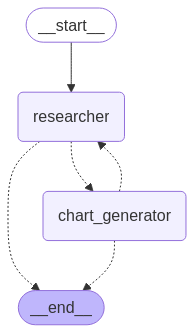

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

{'researcher': {'messages': [HumanMessage(content='Get price of $LINK token over the last month, then draw a line chart of it.Once you draw the char, finish.', additional_kwargs={}, response_metadata={}, id='e8810e03-a6b4-4b28-acc0-dc4fdcf52301'), AIMessage(content=[{'text': "I'll help search for Chainlink (LINK) token price data for the last month. Let me gather this information first.", 'type': 'text'}, {'id': 'toolu_01H7mo7E7a19w43F97FSkU29', 'input': {'query': 'LINK Chainlink token price last 30 days history data'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_017zUXJdtmYEiGrEmWWRxmfr', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 552, 'output_tokens': 99}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-33770f81-ab0e-4d43-89db-835980080ee8-0', tool_calls=[{'name': 'tavily_search

Python REPL can execute arbitrary code. Use with caution.


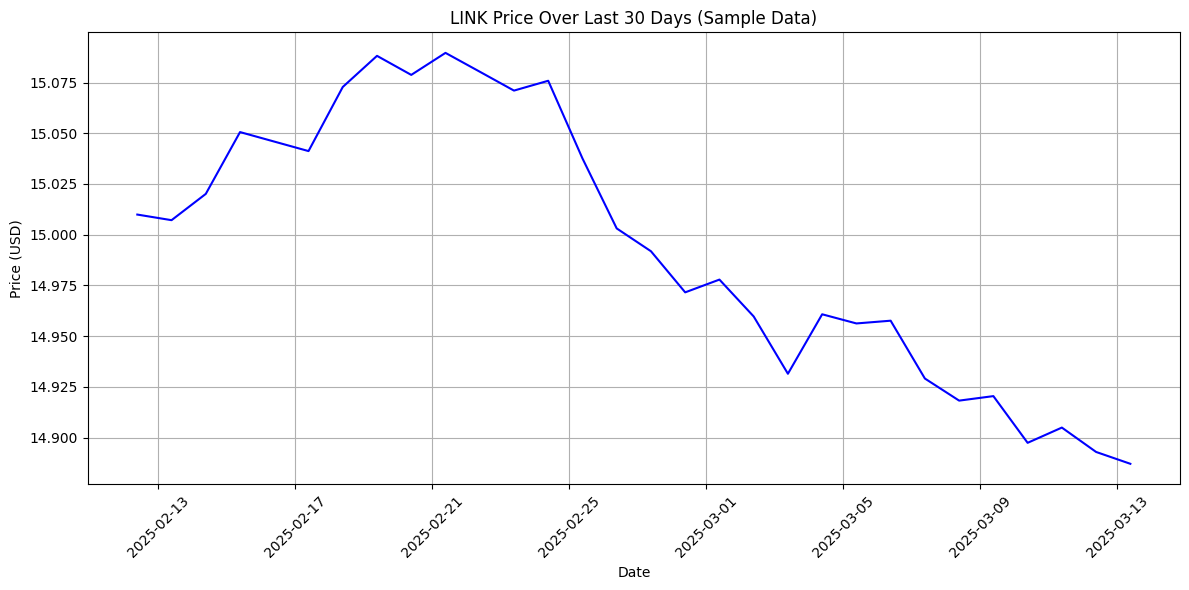

{'chart_generator': {'messages': [HumanMessage(content='Get price of $LINK token over the last month, then draw a line chart of it.Once you draw the char, finish.', additional_kwargs={}, response_metadata={}, id='e8810e03-a6b4-4b28-acc0-dc4fdcf52301'), AIMessage(content=[{'text': "I'll help search for Chainlink (LINK) token price data for the last month. Let me gather this information first.", 'type': 'text'}, {'id': 'toolu_01H7mo7E7a19w43F97FSkU29', 'input': {'query': 'LINK Chainlink token price last 30 days history data'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_017zUXJdtmYEiGrEmWWRxmfr', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 552, 'output_tokens': 99}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-33770f81-ab0e-4d43-89db-835980080ee8-0', tool_calls=[{'name': 'tavily_s

In [8]:
events = graph.stream(
    {
        "messages":[
            (
                "user",
                "Get price of $LINK token over the last month, then draw a line chart of it."
                "Once you draw the char, finish.",
            )
        ],
    },
    {
        "recursion_limit": 150
    }
)
for s in events:
    print(s)
    print('_________')